In [26]:
import scipy.io as sci
import numpy as np
import glob
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import stats
import pylab
import kabuki
import hddm

In [10]:
datapath = 'ExpData/*.mat'
datafiles = np.array(glob.glob(datapath))

In [11]:
flashdata = np.empty((1,5))
beepdata = np.empty((1,5))
for i in np.arange(0, len(datafiles)):
    mat = sci.loadmat(datafiles[i])
    matf = np.insert(mat['mixtrF'], 0, int(i + 1), axis=1)
    accf = np.hstack((matf, mat['accMatF'], mat['resptimeF']))
    matb = np.insert(mat['mixtrB'], 0, int(i + 1), axis=1)
    accb = np.hstack((matb, mat['accMatB'], mat['resptimeB']))
    flashdata = np.vstack((flashdata, accf))
    beepdata = np.vstack((beepdata, accb))
    
flashdata = flashdata[1:]
beepdata = beepdata[1:]

flashframe = pd.DataFrame(flashdata, columns=['subj_idx', 'flashpres', 'beeppres', 'acc', 'rt'])
beepframe = pd.DataFrame(beepdata, columns=['subj_idx', 'flashpres', 'beeppres', 'acc', 'rt'])

congrf = flashframe.loc[flashframe['flashpres'] == flashframe['beeppres']]
unif = flashframe.loc[flashframe['beeppres'] == 0]
congrb = beepframe.loc[beepframe['flashpres'] == beepframe['beeppres']]
unib = beepframe.loc[beepframe['flashpres'] == 0]

def droprow(df, val, less=True):
    if(less):
        return(df.drop(df.index[df['rt'] < val].tolist(), axis=0))
    else:
        return(df.drop(df.index[df['rt'] > val].tolist(), axis=0))
    
def dropsubj(df, val):
    return(df.drop(df.index[df['subj_idx'] == val].tolist(), axis=0))

subject = 15

flashframe = droprow(flashframe, 0.05)
flashframe = dropsubj(flashframe, subject)
flashframe = droprow(flashframe, 10, False)
beepframe = droprow(beepframe, 0.05)
beepframe = dropsubj(beepframe, subject)
beepframe = droprow(beepframe, 10, False)

In [12]:
congrf = flashframe.loc[flashframe['flashpres'] == flashframe['beeppres']]
unif = flashframe.loc[flashframe['beeppres'] == 0]
congrb = beepframe.loc[beepframe['flashpres'] == beepframe['beeppres']]
unib = beepframe.loc[beepframe['flashpres'] == 0]

alldata = pd.concat([flashframe, beepframe])
alldata.columns = ['subj_idx', 'flashpres', 'beeppres', 'response', 'rt']
conditions = [(alldata['flashpres'] == 0) & (alldata['beeppres'] == 2), 
              (alldata['flashpres'] == 0) & (alldata['beeppres'] == 3),
              (alldata['flashpres'] == 2) & (alldata['beeppres'] == 0),
              (alldata['flashpres'] == 3) & (alldata['beeppres'] == 0),
              (alldata['flashpres'] == 2) & (alldata['beeppres'] == 2),
              (alldata['flashpres'] == 3) & (alldata['beeppres'] == 3),]
choices = ['A2', 'A3', 'V2', 'V3', 'A2V2', 'A3V3']
alldata['stimName'] = np.select(conditions, choices)

In [13]:
def formatmodeldata(df, conditions, choices):
    dframe = df.copy()
    dframe.columns = ['subj_idx', 'flashpres', 'beeppres', 'response', 'rt']
    dframe['condition'] = np.select(conditions, choices)
    return(dframe)
    
def stimcode(df, conditions, choices):
    dframe = df.copy()
    dframe['stimCode'] = np.select(conditions, choices)
    return(dframe)



In [14]:
model_unif = formatmodeldata(unif, [(unif['flashpres'] == 2), (unif['flashpres'] == 3)], ['F2', 'F3'])
#model_unif = formatmodeldata(unif, [(unif['flashpres'] == 2), (unif['flashpres'] == 3)], ['easy', 'hard'])
model_unib = formatmodeldata(unib, [(unib['beeppres'] == 2), (unib['beeppres'] == 3)], ['B2', 'B3'])
model_congrf = formatmodeldata(congrf, [(congrf['flashpres'] == 2) & (congrf['beeppres'] == 2),
                                        (congrf['flashpres'] == 3) & (congrf['beeppres'] == 3)], ['F2B2', 'F3B3'])
model_congrb = formatmodeldata(congrb, [(congrb['flashpres'] == 2) & (congrb['beeppres'] == 2),
                                        (congrb['flashpres'] == 3) & (congrb['beeppres'] == 3)], ['F2B2', 'F3B3'])

stim_unif = stimcode(model_unif, [(model_unif['flashpres'] == 2) & (model_unif['response'] == 0), 
                                  (model_unif['flashpres'] == 2) & (model_unif['response'] == 1),
                                  (model_unif['flashpres'] == 3) & (model_unif['response'] == 0),
                                  (model_unif['flashpres'] == 3) & (model_unif['response'] == 1)], [1, 0, 0, 1])
stim_congrf = stimcode(model_congrf, [(model_congrf['flashpres'] == 2) & (model_congrf['response'] == 0), 
                                      (model_congrf['flashpres'] == 2) & (model_congrf['response'] == 1),
                                      (model_congrf['flashpres'] == 3) & (model_congrf['response'] == 0),
                                      (model_congrf['flashpres'] == 3) & (model_congrf['response'] == 1)], [1, 0, 0, 1])
stim_unib = stimcode(model_unib, [(model_unib['beeppres'] == 2) & (model_unib['response'] == 0), 
                                  (model_unib['beeppres'] == 2) & (model_unib['response'] == 1),
                                  (model_unib['beeppres'] == 3) & (model_unib['response'] == 0),
                                  (model_unib['beeppres'] == 3) & (model_unib['response'] == 1)], [1, 0, 0, 1])
stim_congrb = stimcode(model_congrb, [(model_congrb['beeppres'] == 2) & (model_congrb['response'] == 0), 
                                      (model_congrb['beeppres'] == 2) & (model_congrb['response'] == 1),
                                      (model_congrb['beeppres'] == 3) & (model_congrb['response'] == 0),
                                      (model_congrb['beeppres'] == 3) & (model_congrb['response'] == 1)], [1, 0, 0, 1])

## Unisensory Flash

In [68]:
unif_acc = hddm.HDDM(model_unif, include=['a', 'v', 't', 'p_outlier'])
unif_acc.sample(5000, burn=200)

 [-----------------100%-----------------] 5000 of 5000 complete in 153.1 sec

Plotting a
Plotting a_std
Plotting v
Plotting t


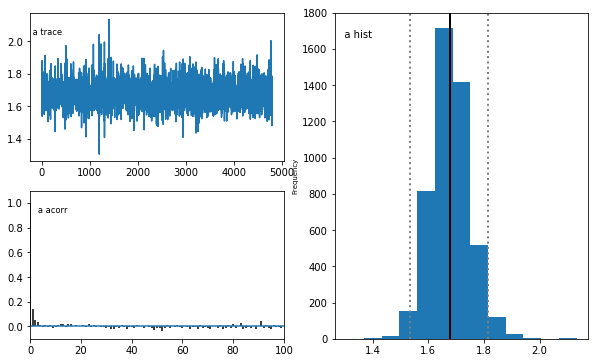

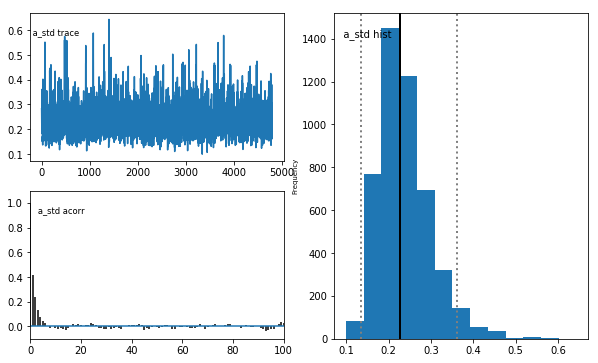

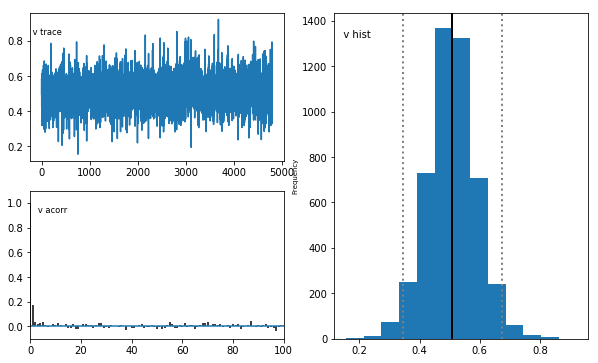

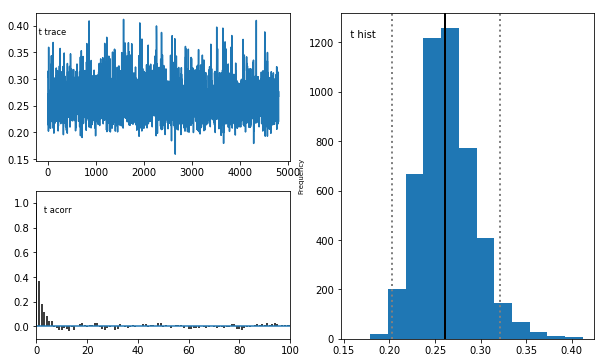

In [75]:
unif_acc.plot_posteriors(['a', 't', 'v', 'a_std'])
#unif_acc.print_stats()

In [19]:
unif_acc2 = hddm.HDDM(model_unif, include=['a', 'v', 't', 'p_outlier'])
unif_acc2.sample(10000, burn=1000)

 [-----------------100%-----------------] 10000 of 10000 complete in 541.4 sec

Plotting a
Plotting a_std
Plotting v
Plotting t
                 mean       std      2.5q       25q       50q       75q     97.5q    mc err
a            1.484715  0.057421  1.379358  1.447241  1.481830  1.519679  1.605492  0.001194
a_std        0.182553  0.052323  0.101163  0.146104  0.174964  0.209802  0.306949  0.001421
a_subj.1.0   1.717821  0.104880  1.499422  1.650989  1.718015  1.787210  1.923262  0.002972
a_subj.2.0   1.495894  0.077787  1.345994  1.443546  1.494546  1.545683  1.656827  0.001571
a_subj.3.0   1.323422  0.066250  1.197673  1.278057  1.322245  1.367204  1.458492  0.001169
a_subj.4.0   1.421996  0.080134  1.277336  1.366823  1.418808  1.473990  1.588071  0.001727
a_subj.5.0   1.447611  0.078624  1.302976  1.392488  1.444268  1.498978  1.609886  0.001419
a_subj.6.0   1.661732  0.088680  1.495432  1.601148  1.659250  1.719090  1.843122  0.002191
a_subj.7.0   1.683751  0.082381  1.524724  1.629473  1.680578  1.738098  1.852633  0.001722
a_subj.8.0   1.462223  0.076864 

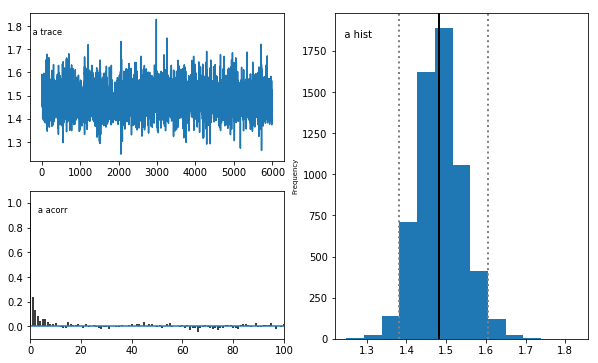

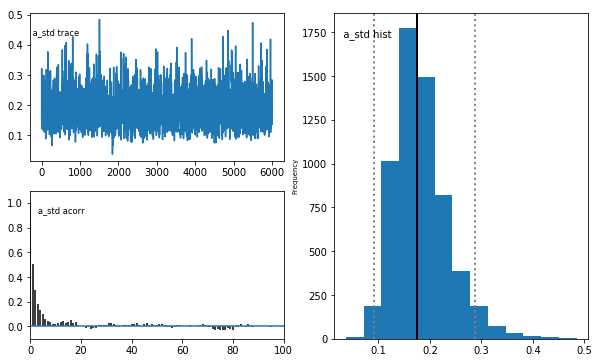

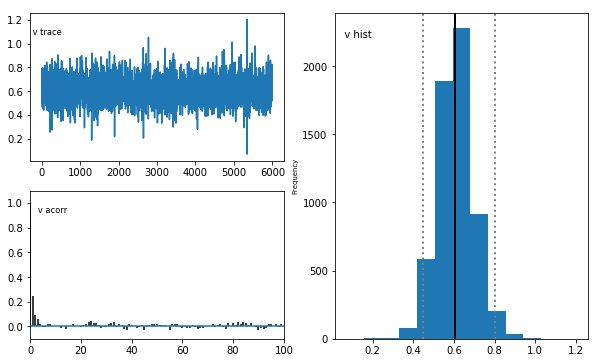

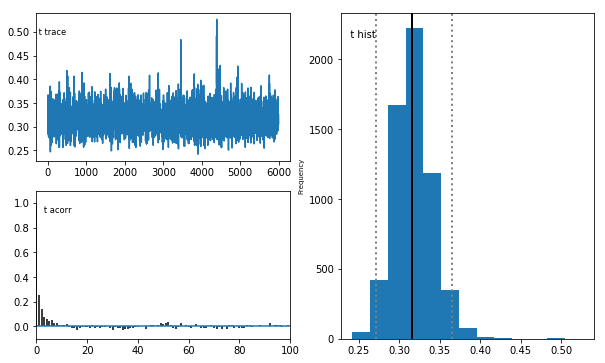

In [96]:
unif_acc2.plot_posteriors(['a', 't', 'v', 'a_std'])
unif_acc2.print_stats()

In [20]:
#ppc_data = hddm.utils.post_pred_gen(unif_acc)
ppc_data = hddm.utils.post_pred_gen(unif_acc2)

 [---------------------121%---------------------] 17 of 14 complete in 754.2 sec

In [21]:
ppc_compare = hddm.utils.post_pred_stats(model_unif, ppc_data)

In [22]:
print(ppc_compare)

          observed      mean       std       SEM       MSE credible  \
stat                                                                  
accuracy  0.686429  0.703397  0.082791  0.000288  0.007142     True   
mean_ub   0.887804  0.829951  0.149934  0.003347  0.025827     True   
std_ub    0.648511  0.406711  0.111804  0.058467  0.070967     True   
10q_ub    0.462525  0.458159  0.082325  0.000019  0.006796     True   
30q_ub    0.587809  0.571165  0.101445  0.000277  0.010568     True   
50q_ub    0.697033  0.710438  0.129840  0.000180  0.017038     True   
70q_ub    0.880054  0.917707  0.176973  0.001418  0.032737     True   
90q_ub    1.420841  1.350920  0.285826  0.004889  0.086586     True   
mean_lb  -0.952815 -0.829775  0.163395  0.015139  0.041837     True   
std_lb    0.757407  0.395160  0.134739  0.131223  0.149377    False   
10q_lb    0.445137  0.467537  0.088134  0.000502  0.008269     True   
30q_lb    0.601725  0.577870  0.110257  0.000569  0.012726     True   
50q_lb

In [69]:
ppc_data_pooled = hddm.utils.post_pred_gen(unif_acc, groupby=['condition'])

NotImplementedError: Supply a grouping so that at most 1 observed node codes for each group.

In [50]:
data, params = hddm.generate.gen_rand_data(params={'easy': {'v': 1, 'a': 2, 't': .3},
                                                   'hard': {'v': 1, 'a': 2, 't': .3}})
data.head(10)

,rt,response,subj_idx,condition
0,0.675,1.0,0,hard
1,1.059,1.0,0,hard
2,1.166,1.0,0,hard
3,1.341,1.0,0,hard
4,1.061,1.0,0,hard
5,0.499,1.0,0,hard
6,0.808,1.0,0,hard
7,0.671,1.0,0,hard
8,0.432,1.0,0,hard
9,1.332,1.0,0,hard


In [108]:
data, params = hddm.generate.gen_rand_data(params={'v': 0.608221, 'a': 1.484715, 't': 0.317067}, size = 200, subjs = 14)
data.head(10)

,rt,response,subj_idx,condition
0,0.894667,0.0,0,none
1,0.902667,1.0,0,none
2,0.886667,1.0,0,none
3,1.060667,1.0,0,none
4,0.617667,1.0,0,none
5,0.800667,0.0,0,none
6,0.914667,1.0,0,none
7,0.628667,0.0,0,none
8,0.789667,1.0,0,none
9,0.875667,0.0,0,none


In [109]:
paramrec = hddm.HDDM(data, include=['a', 'v', 't', 'p_outlier'])
paramrec.sample(7000, burn=500)

 [-----------------100%-----------------] 7000 of 7000 complete in 464.8 sec

In [110]:
paramrec.print_stats()

                 mean          std         2.5q          25q          50q         75q       97.5q       mc err
a             1.47885    0.0301362      1.41988      1.45979      1.47842     1.49768     1.53984  0.000573732
a_std        0.095583    0.0278595    0.0526274    0.0763705    0.0912185     0.11035    0.161551  0.000737603
a_subj.0      1.53691    0.0466531      1.45069      1.50567      1.53468     1.56615     1.63471  0.000840509
a_subj.1      1.44029    0.0435872      1.35746      1.41093      1.43963     1.46921     1.52711  0.000751445
a_subj.2      1.40149    0.0436933      1.31967      1.37152      1.40022     1.43048      1.4908  0.000829698
a_subj.3      1.39539    0.0448319       1.3106      1.36507       1.3944     1.42513     1.48734   0.00101733
a_subj.4      1.52624    0.0473082      1.43672      1.49436      1.52518     1.55722     1.62428  0.000952462
a_subj.5      1.55021    0.0483086      1.45999      1.51747      1.54815     1.58116     1.64936  0.000966605
a

In [17]:
models = []
for i in range(5):
    m = hddm.HDDM(model_unif)
    m.sample(5000, burn=200)
    models.append(m)

hddm.analyze.gelman_rubin(models)

 [-----------------100%-----------------] 5000 of 5000 complete in 147.8 sec

{'a': 0.9999222681696317,
 'a_std': 1.0000408953871203,
 'a_subj.1.0': 1.0002133905516022,
 'a_subj.10.0': 1.0001226183871754,
 'a_subj.11.0': 1.0001082879811638,
 'a_subj.12.0': 1.0000349835089308,
 'a_subj.13.0': 1.000176245844638,
 'a_subj.14.0': 1.0003137809933766,
 'a_subj.2.0': 1.0001883089925165,
 'a_subj.3.0': 1.0000750975491692,
 'a_subj.4.0': 1.0001661738218441,
 'a_subj.5.0': 1.0001712651656596,
 'a_subj.6.0': 1.0000029426746369,
 'a_subj.7.0': 1.0001846461721673,
 'a_subj.8.0': 1.0000112229488407,
 'a_subj.9.0': 1.0000848812948575,
 't': 1.0001377657889616,
 't_std': 1.0001872365939963,
 't_subj.1.0': 1.0001394224319744,
 't_subj.10.0': 1.0001253793462652,
 't_subj.11.0': 0.9999616877130169,
 't_subj.12.0': 1.0000316954085458,
 't_subj.13.0': 1.0003481936430751,
 't_subj.14.0': 1.000394324475175,
 't_subj.2.0': 1.0003951495791392,
 't_subj.3.0': 0.9999190090686131,
 't_subj.4.0': 1.0000305321607428,
 't_subj.5.0': 1.000036930579638,
 't_subj.6.0': 1.0000970759819716,
 't_su

## Bisensory Flash

In [23]:
congrf_acc = hddm.HDDM(model_congrf, include=['a', 'v', 't', 'p_outlier'])
congrf_acc.sample(7000, burn=500)

 [-----------------100%-----------------] 7000 of 7000 complete in 382.3 sec

Plotting a
Plotting a_std
Plotting v
Plotting t
                 mean       std      2.5q       25q       50q       75q     97.5q    mc err
a            1.897409  0.129276  1.665064  1.812904  1.890497  1.971885  2.176320  0.003530
a_std        0.423255  0.119796  0.253076  0.341203  0.403749  0.479180  0.712926  0.003311
a_subj.1.0   2.250299  0.180565  1.939031  2.126333  2.234231  2.357773  2.653976  0.004137
a_subj.2.0   2.448964  0.182141  2.127800  2.322733  2.435460  2.564308  2.839804  0.005207
a_subj.3.0   1.845812  0.273122  1.390880  1.651112  1.817833  2.015735  2.440909  0.014438
a_subj.4.0   1.657667  0.095189  1.465537  1.595393  1.657829  1.723674  1.839051  0.002224
a_subj.5.0   2.074810  0.127365  1.833177  1.989946  2.070575  2.159767  2.334920  0.002744
a_subj.6.0   1.829263  0.115853  1.622533  1.747027  1.822749  1.902542  2.075031  0.002550
a_subj.7.0   2.295094  0.270679  1.838935  2.108772  2.270438  2.454723  2.885408  0.010977
a_subj.8.0   2.130242  0.267811 

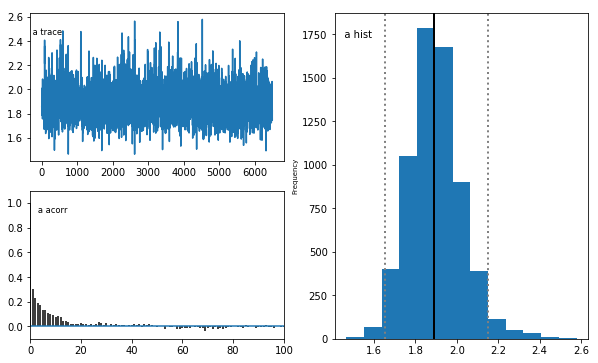

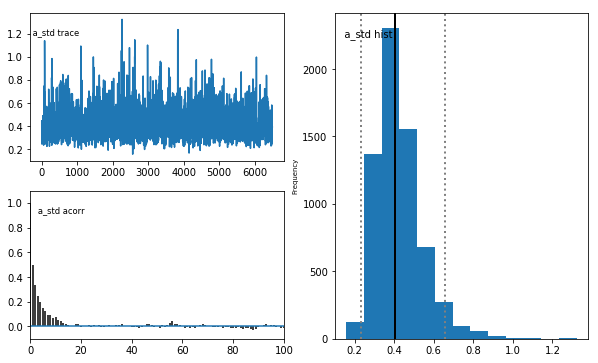

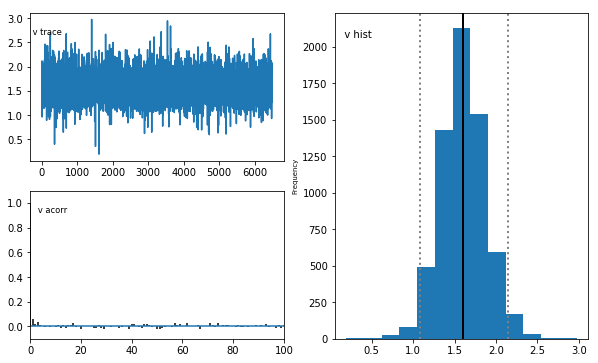

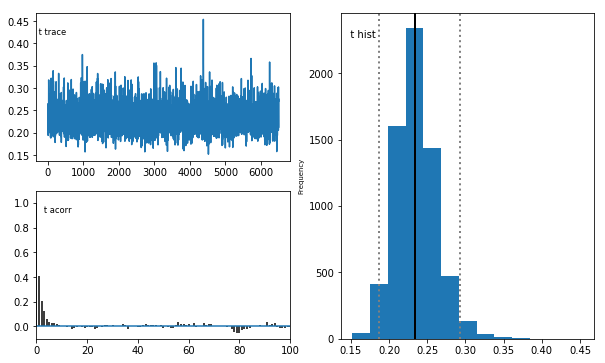

In [24]:
congrf_acc.plot_posteriors(['a', 't', 'v', 'a_std'])
congrf_acc.print_stats()

In [21]:
ppc_data2 = hddm.utils.post_pred_gen(congrf_acc)

 [---------------------121%---------------------] 17 of 14 complete in 621.8 sec

In [28]:
ppc_compare2 = hddm.utils.post_pred_stats(model_congrf, ppc_data2)
print(ppc_compare2)

          observed      mean       std       SEM       MSE credible  \
stat                                                                  
accuracy  0.869907  0.902796  0.101524  0.001082  0.011389     True   
mean_ub   0.829872  0.791652  0.244413  0.001461  0.061198     True   
std_ub    0.678320  0.404584  0.187778  0.074931  0.110192     True   
10q_ub    0.361233  0.414767  0.100212  0.002866  0.012908     True   
30q_ub    0.484017  0.537091  0.140198  0.002817  0.022472     True   
50q_ub    0.625160  0.678087  0.196087  0.002801  0.041251     True   
70q_ub    0.822553  0.882200  0.284995  0.003558  0.084780     True   
90q_ub    1.473333  1.311027  0.481534  0.026343  0.258218     True   
mean_lb  -1.407211 -0.828656  0.301021  0.334726  0.425340     True   
std_lb    1.119768  0.350465  0.265937  0.591827  0.662549    False   
10q_lb    0.444729  0.510753  0.185139  0.004359  0.038636     True   
30q_lb    0.752584  0.614865  0.217269  0.018966  0.066172     True   
50q_lb

In [123]:
data, params = hddm.generate.gen_rand_data(params={'v': 1.600894, 'a': 1.896518, 't': 0.235799}, size = 200, subjs = 14)

In [124]:
paramrec2 = hddm.HDDM(data, include=['a', 'v', 't', 'p_outlier'])
paramrec2.sample(7000, burn=500)

 [-----------------100%-----------------] 7000 of 7000 complete in 479.6 sec

In [125]:
paramrec2.print_stats()

                 mean          std        2.5q          25q          50q         75q       97.5q       mc err
a             1.91621    0.0514901     1.81849      1.88309       1.9143     1.94763     2.02399   0.00122058
a_std        0.154107    0.0481866    0.078478     0.120946      0.14768    0.180205    0.265956   0.00165546
a_subj.0      1.99821    0.0876495     1.83495      1.93698      1.99482     2.05624     2.17778   0.00237459
a_subj.1      1.77469    0.0804171      1.6229      1.71783      1.77322     1.83039     1.93201   0.00237097
a_subj.2      2.04343     0.090157     1.88034      1.98298      2.03815     2.09908     2.23828   0.00253073
a_subj.3      1.84427    0.0835243     1.68505      1.78695      1.84193     1.90079     2.01271   0.00215585
a_subj.4      2.06393    0.0942722     1.89928      1.99828      2.05635     2.12262     2.27002   0.00273551
a_subj.5      2.06975    0.0993983     1.89249      1.99889      2.06443      2.1343     2.27969   0.00249286
a_subj.6  

In [28]:
ppc_data_pooled = hddm.utils.post_pred_gen(congrf_acc, groupby=['condition', 'subj_idx'])

 [----------------------------------------221%----------------------------------------] 31 of 14 complete in 1773.7 sec

ValueError: Length of names must match number of levels in MultiIndex.

In [29]:
ppc_compare = hddm.utils.post_pred_stats(model_congrf, ppc_data_pooled)

NameError: name 'ppc_data_pooled' is not defined

In [20]:
models = []
for i in range(5):
    m = hddm.HDDM(model_congrf)
    m.sample(7000, burn=500)
    models.append(m)

hddm.analyze.gelman_rubin(models)

 [-----------------100%-----------------] 5000 of 5000 complete in 152.3 sec

{'a': 1.0000474073169563,
 'a_std': 1.0005838244736438,
 'a_subj.1.0': 0.9999854551580909,
 'a_subj.10.0': 1.000060321616504,
 'a_subj.11.0': 1.0000919352975937,
 'a_subj.12.0': 1.0006461977533647,
 'a_subj.13.0': 1.0012288542140955,
 'a_subj.14.0': 0.999960685161328,
 'a_subj.2.0': 1.0001714013451324,
 'a_subj.3.0': 1.0018968825909345,
 'a_subj.4.0': 1.000292165584815,
 'a_subj.5.0': 1.0002558580133434,
 'a_subj.6.0': 1.000395366284813,
 'a_subj.7.0': 1.000234840275355,
 'a_subj.8.0': 1.0011017862397926,
 'a_subj.9.0': 1.0000799640535685,
 't': 1.0003903628123125,
 't_std': 1.000657351342166,
 't_subj.1.0': 0.9999345286449514,
 't_subj.10.0': 1.0002045026973458,
 't_subj.11.0': 0.9999716653514928,
 't_subj.12.0': 1.000879091824103,
 't_subj.13.0': 1.0009311005895618,
 't_subj.14.0': 1.0001032327505526,
 't_subj.2.0': 1.0003894870764503,
 't_subj.3.0': 1.0013048088844685,
 't_subj.4.0': 1.0001518792228128,
 't_subj.5.0': 1.0002523251522801,
 't_subj.6.0': 1.0004056797264402,
 't_subj.7

## Unisensory Beep

In [126]:
unib_acc = hddm.HDDM(model_unib, include=['a', 'v', 't', 'p_outlier'])
unib_acc.sample(7000, burn=500)

 [-----------------100%-----------------] 7000 of 7000 complete in 295.1 sec

In [128]:
#unib_acc.plot_posteriors(['a', 't', 'v', 'a_std'])
unib_acc.print_stats()

                 mean       std      2.5q       25q       50q       75q     97.5q    mc err
a            2.253360  0.171196  1.963184  2.136615  2.239751  2.352783  2.636361  0.009072
a_std        0.445593  0.159171  0.206021  0.334318  0.422515  0.528542  0.826356  0.007850
a_subj.1.0   2.749454  0.331339  2.210188  2.513658  2.709771  2.933220  3.549033  0.016004
a_subj.2.0   1.953496  0.144288  1.705081  1.851182  1.942715  2.043159  2.261063  0.003585
a_subj.3.0   2.134480  0.319727  1.623876  1.907043  2.094081  2.322712  2.846201  0.016333
a_subj.4.0   1.917220  0.109929  1.706447  1.842257  1.916139  1.988673  2.138727  0.002388
a_subj.5.0   2.393800  0.147333  2.126256  2.291021  2.386310  2.490644  2.703490  0.003632
a_subj.6.0   2.815221  0.377571  2.203803  2.544450  2.768467  3.036333  3.718833  0.019524
a_subj.7.0   2.351231  0.223422  1.977049  2.192392  2.334440  2.493144  2.828318  0.008256
a_subj.8.0   2.587960  0.384802  1.968994  2.308086  2.538497  2.815892  3.45606

In [25]:
ppc_data3 = hddm.utils.post_pred_gen(unib_acc)

 [---------------------121%---------------------] 17 of 14 complete in 714.6 sec

In [29]:
ppc_compare3 = hddm.utils.post_pred_stats(model_unib, ppc_data3)
print(ppc_compare3)

          observed      mean       std       SEM       MSE credible  \
stat                                                                  
accuracy  0.932857  0.960414  0.073083  0.000759  0.006101     True   
mean_ub   0.837362  0.775178  0.223704  0.003867  0.053910     True   
std_ub    0.666654  0.348508  0.184889  0.101217  0.135401     True   
10q_ub    0.415278  0.440795  0.079531  0.000651  0.006976     True   
30q_ub    0.528659  0.557079  0.118207  0.000808  0.014780     True   
50q_ub    0.648617  0.684053  0.173723  0.001256  0.031435     True   
70q_ub    0.825630  0.860554  0.261304  0.001220  0.069500     True   
90q_ub    1.386294  1.223901  0.457434  0.026372  0.235618     True   
mean_lb  -1.496485 -0.866543  0.333215  0.396827  0.507860     True   
std_lb    1.467681  0.294176  0.313083  1.377115  1.475136    False   
10q_lb    0.522123  0.600637  0.214533  0.006164  0.052189     True   
30q_lb    0.696052  0.689686  0.232590  0.000041  0.054138     True   
50q_lb

In [132]:
data, params = hddm.generate.gen_rand_data(params={'v': 2.178818, 'a': 2.253360, 't': 0.235935}, size = 200, subjs = 14)

In [130]:
paramrec3 = hddm.HDDM(data, include=['a', 'v', 't', 'p_outlier'])
paramrec3.sample(7000, burn=500)

 [-----------------100%-----------------] 7000 of 7000 complete in 580.5 sec

In [131]:
paramrec3.print_stats()

                  mean          std         2.5q          25q          50q          75q       97.5q       mc err
a              2.21521    0.0788721      2.06916      2.16265      2.21178      2.26449     2.38265    0.0031499
a_std          0.21628    0.0731979     0.100709     0.167238     0.206409     0.253914     0.39314   0.00292559
a_subj.0       2.33849     0.134439      2.09739       2.2446      2.32845       2.4226      2.6265   0.00516967
a_subj.1       1.95857      0.10789      1.75815      1.88527      1.95552      2.02839     2.18293   0.00382522
a_subj.2       2.15108     0.123167      1.92392      2.06506      2.14509      2.23379     2.40546   0.00403024
a_subj.3       1.85768     0.116303      1.64079      1.77817      1.85096      1.93187     2.10468   0.00457998
a_subj.4       2.32102     0.129051      2.08494      2.22978      2.31722      2.40705     2.59679   0.00493422
a_subj.5        2.3949     0.146406        2.136      2.29247      2.38584      2.48918     2.70

In [23]:
models = []
for i in range(5):
    m = hddm.HDDM(model_unib)
    m.sample(5000, burn=200)
    models.append(m)

hddm.analyze.gelman_rubin(models)

 [-----------------100%-----------------] 5000 of 5000 complete in 146.4 sec

{'a': 1.000039707178758,
 'a_std': 1.0002919153202265,
 'a_subj.1.0': 1.000136333303343,
 'a_subj.10.0': 1.0002770643821113,
 'a_subj.11.0': 1.0001526059134447,
 'a_subj.12.0': 1.0003673273176577,
 'a_subj.13.0': 0.9999362332563375,
 'a_subj.14.0': 1.0016714330875802,
 'a_subj.2.0': 1.0000919737432583,
 'a_subj.3.0': 1.0005894986480675,
 'a_subj.4.0': 1.0001806021993587,
 'a_subj.5.0': 1.0006546264817833,
 'a_subj.6.0': 1.0000996395120163,
 'a_subj.7.0': 1.0001220514212645,
 'a_subj.8.0': 1.0003225376120914,
 'a_subj.9.0': 1.0008267422582036,
 't': 1.0004150978972126,
 't_std': 1.0005088559002258,
 't_subj.1.0': 1.0000861806254808,
 't_subj.10.0': 1.0004638451014845,
 't_subj.11.0': 1.0000320927611415,
 't_subj.12.0': 1.0003356887060935,
 't_subj.13.0': 1.0000101764881533,
 't_subj.14.0': 1.0015307384025476,
 't_subj.2.0': 1.0001646302270735,
 't_subj.3.0': 1.000734663358436,
 't_subj.4.0': 1.000295341095813,
 't_subj.5.0': 1.0004536495977283,
 't_subj.6.0': 1.0001823001227987,
 't_sub

## Bisensory Beep

In [136]:
congrb_acc = hddm.HDDM(model_congrb, include=['a', 'v', 't', 'p_outlier'])
congrb_acc.sample(5000, burn=200)

 [-----------------100%-----------------] 5000 of 5000 complete in 189.2 sec

Plotting a
Plotting a_std
Plotting v
Plotting t
                 mean       std      2.5q       25q       50q       75q     97.5q    mc err
a            2.300615  0.132508  2.062364  2.209325  2.289004  2.381358  2.586807  0.007157
a_std        0.300480  0.123832  0.083987  0.217074  0.288139  0.374562  0.572063  0.006991
a_subj.1.0   2.619966  0.251140  2.175751  2.436986  2.599643  2.785328  3.153572  0.013461
a_subj.2.0   2.186493  0.161296  1.893941  2.074649  2.176042  2.285020  2.524366  0.005367
a_subj.3.0   2.188200  0.262396  1.688341  2.009694  2.182155  2.351513  2.749728  0.014379
a_subj.4.0   1.986443  0.122026  1.753580  1.902951  1.984797  2.069272  2.225535  0.004100
a_subj.5.0   2.264096  0.114943  2.048139  2.184701  2.260173  2.339682  2.501736  0.003103
a_subj.6.0   2.468847  0.298234  2.003633  2.250814  2.428806  2.648137  3.143691  0.016845
a_subj.7.0   2.468627  0.237714  2.063323  2.299688  2.449251  2.611039  2.990742  0.011489
a_subj.8.0   2.418489  0.243310 

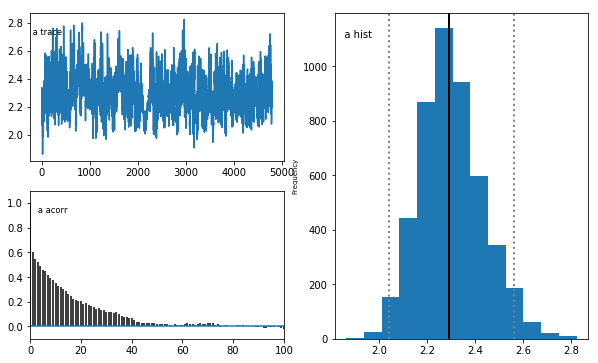

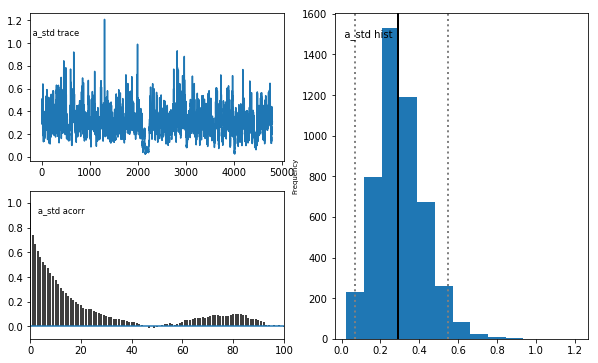

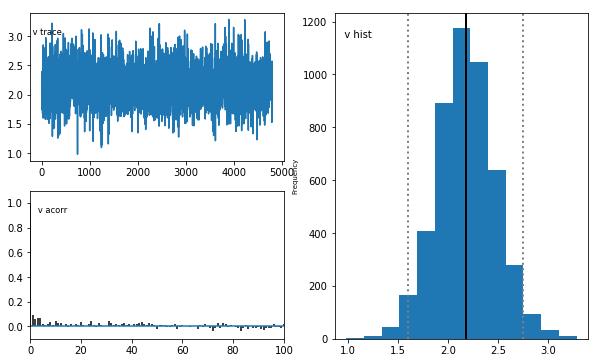

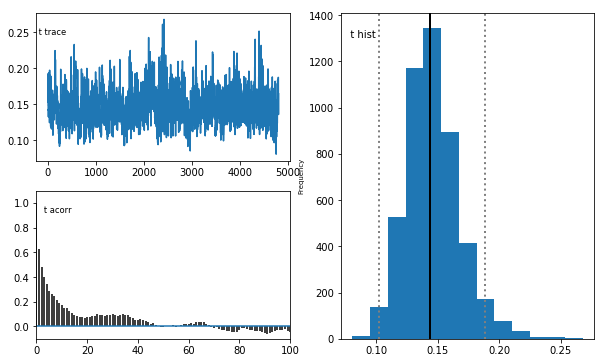

In [152]:
congrb_acc.plot_posteriors(['a', 't', 'v', 'a_std'])
congrb_acc.print_stats()

In [159]:
congrb_acc2 = hddm.HDDM(model_congrb, include=['a', 'v', 't', 'p_outlier'])
congrb_acc2.sample(10000, burn=1000)

 [-----------------100%-----------------] 10000 of 10000 complete in 348.2 sec

Plotting a
Plotting a_std
Plotting v
Plotting t
                 mean       std      2.5q       25q       50q       75q     97.5q    mc err
a            2.308111  0.130415  2.072300  2.220699  2.297792  2.385236  2.590597  0.005857
a_std        0.305229  0.127475  0.101134  0.213195  0.290667  0.379409  0.604173  0.006405
a_subj.1.0   2.617701  0.250847  2.205378  2.436775  2.591086  2.770677  3.170776  0.010433
a_subj.2.0   2.188505  0.157258  1.895872  2.082262  2.182346  2.289207  2.513912  0.003853
a_subj.3.0   2.195414  0.264034  1.687142  2.017810  2.192962  2.365915  2.728997  0.010408
a_subj.4.0   1.984124  0.125655  1.737565  1.899057  1.984866  2.067880  2.232641  0.003199
a_subj.5.0   2.268318  0.121855  2.040163  2.183953  2.265414  2.346583  2.519597  0.002239
a_subj.6.0   2.472364  0.293192  2.014632  2.264049  2.426302  2.636538  3.164453  0.013388
a_subj.7.0   2.477617  0.235248  2.079216  2.311980  2.452863  2.620556  3.005093  0.008777
a_subj.8.0   2.421337  0.250918 

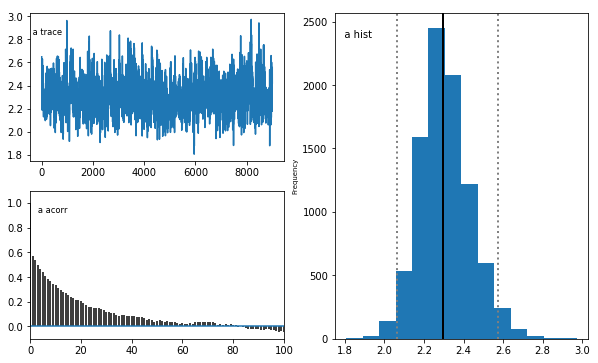

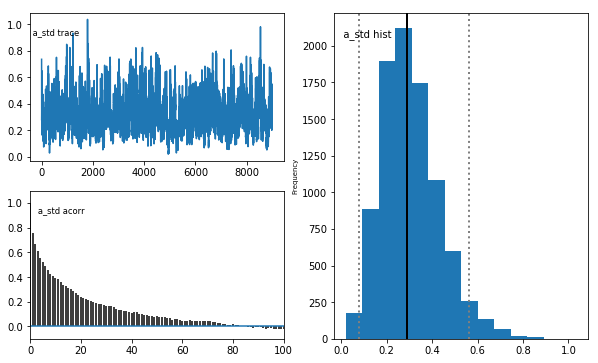

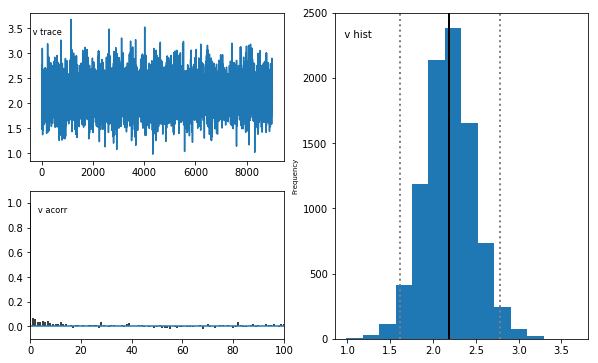

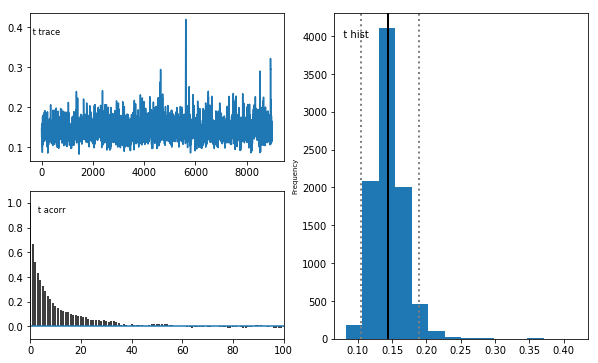

In [160]:
congrb_acc2.plot_posteriors(['a', 't', 'v', 'a_std'])
congrb_acc2.print_stats()

In [27]:
ppc_data4 = hddm.utils.post_pred_gen(congrb_acc)

 [---------------------121%---------------------] 17 of 14 complete in 664.1 sec

In [30]:
ppc_compare4 = hddm.utils.post_pred_stats(model_congrb, ppc_data4)
print(ppc_compare4)

          observed      mean       std       SEM       MSE credible  \
stat                                                                  
accuracy  0.939155  0.963768  0.066537  0.000606  0.005033     True   
mean_ub   0.786403  0.711602  0.246108  0.005595  0.066164     True   
std_ub    0.740852  0.369112  0.210989  0.138191  0.182707     True   
10q_ub    0.328237  0.358368  0.080943  0.000908  0.007460     True   
30q_ub    0.445033  0.480957  0.125613  0.001291  0.017069     True   
50q_ub    0.568527  0.613924  0.188247  0.002061  0.037498     True   
70q_ub    0.734728  0.801574  0.289085  0.004469  0.088039     True   
90q_ub    1.402548  1.187051  0.514914  0.046439  0.311575     True   
mean_lb  -1.538495 -0.848860  0.365395  0.475596  0.609109     True   
std_lb    1.428993  0.331162  0.332747  1.205232  1.315953    False   
10q_lb    0.492013  0.547626  0.265292  0.003093  0.073473     True   
30q_lb    0.762311  0.649726  0.278995  0.012675  0.090514     True   
50q_lb

In [161]:
data, params = hddm.generate.gen_rand_data(params={'v': 2.190644, 'a': 2.308111, 't': 0.145680}, size = 200, subjs = 14)

In [162]:
paramrec4 = hddm.HDDM(data, include=['a', 'v', 't', 'p_outlier'])
paramrec4.sample(10000, burn=1000)

 [-----------------100%-----------------] 10000 of 10000 complete in 668.6 sec

In [163]:
paramrec4.print_stats()

                  mean          std         2.5q          25q          50q          75q       97.5q       mc err
a              2.34988    0.0936108      2.17412      2.28941      2.34571       2.4045     2.55137   0.00362909
a_std         0.248943    0.0838113     0.118103     0.191948     0.238068     0.293832    0.450208   0.00283267
a_subj.0       2.35317     0.128676      2.11688      2.26553      2.34781      2.43531     2.62636   0.00415827
a_subj.1       2.47685      0.16354      2.19031      2.36121      2.46604      2.57708     2.83349   0.00638031
a_subj.2       2.50789      0.16407      2.22021      2.39481      2.49283      2.60566     2.86615   0.00669278
a_subj.3       2.02946     0.130655      1.78932      1.93979      2.02455      2.11367     2.30342   0.00443605
a_subj.4       2.12885     0.136504      1.86885      2.03691      2.12652      2.21843     2.40323   0.00497259
a_subj.5       2.17776     0.134857      1.93013      2.08432      2.17234      2.26392      2.4

In [26]:
models = []
for i in range(5):
    m = hddm.HDDM(model_congrb)
    m.sample(5000, burn=200)
    models.append(m)

hddm.analyze.gelman_rubin(models)

 [-----------------100%-----------------] 5000 of 5000 complete in 156.6 sec

{'a': 1.0002682460717376,
 'a_std': 1.000438919551244,
 'a_subj.1.0': 1.000238481258267,
 'a_subj.10.0': 0.9999464361643808,
 'a_subj.11.0': 1.0009590336300769,
 'a_subj.12.0': 1.0009828434054724,
 'a_subj.13.0': 1.000172549445403,
 'a_subj.14.0': 1.0016162243909308,
 'a_subj.2.0': 0.9999532243347793,
 'a_subj.3.0': 1.0005622519864017,
 'a_subj.4.0': 1.0002420717024463,
 'a_subj.5.0': 1.000052825461721,
 'a_subj.6.0': 1.0003760303869051,
 'a_subj.7.0': 1.0002237344949094,
 'a_subj.8.0': 1.0009967863483986,
 'a_subj.9.0': 1.0005362653656213,
 't': 1.0012295705645806,
 't_std': 1.0023593568920406,
 't_subj.1.0': 1.0003241973467085,
 't_subj.10.0': 1.0003005382206678,
 't_subj.11.0': 1.000921048039567,
 't_subj.12.0': 1.0008148173321014,
 't_subj.13.0': 1.0001604196895173,
 't_subj.14.0': 1.0018719812359702,
 't_subj.2.0': 1.000150551458367,
 't_subj.3.0': 1.0003459051526236,
 't_subj.4.0': 1.0000925678692871,
 't_subj.5.0': 1.0003223054388617,
 't_subj.6.0': 1.0005941186895402,
 't_subj.